In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import cmaps
import metpy.calc as mpcalc
from metpy.units import units

import geocat.datafiles as gdf
import geocat.viz as gv


In [2]:
def add_height_from_pressure_axis(ax,
                                             heights=None,
                                             pressure_units='hPa',
                                             ticklabelsize=12,
                                             label='Height (km)',
                                             labelpad=10,
                                             axislabelsize=16):
    """Utility function that adds a right-hand Height axis to the plot, derived
    from the left-hand Pressure axis.

    Parameters
    ----------

        ax (:class:`matplotlib.axes._subplots.AxesSubplot` or :class:`cartopy.mpl.geoaxes.GeoAxesSubplot`):
            Current axes to the current figure

        heights (:class:`numpy.ndarray` or list):
            An array of desired height values in km.

        pressure_units (:class:`str`):
            The Pint-compliant unit string associated with the Pressure values. Assume to be hPa.

        ticklabelsize (:class:`int`):
            Text font size of tick labels. A default value of 12 is used if nothing is set.

        label (:class:`str`):
            Text to use for the right hand side label.

        labelpad (:class:`float`):
            Spacing in points from the axes bounding box. A default value of 10 is used if nothing is set.

        axislabelsize (:class:`int`):
            Text font size for y-axes. A default value of 16 is used if nothing is set.

        Returns
        -------

        axRHS (:class:`matplotlib.axes._subplots.AxesSubplot` or :class:`cartopy.mpl.geoaxes.GeoAxesSubplot`):
            The created right-hand axis
    """
    axRHS = ax.twinx()

    # If height array isn't given, infer it from pressure axis
    if heights is None:
        height_min, height_max = mpcalc.pressure_to_height_std(
            ax.get_ylim() * units(pressure_units)).magnitude

        height_range = abs(height_max - height_min)
        if (height_range < 35):
            if (height_range < 70):
                step = 7
            else:
                step = 4
        else:
            step = 10

        # Select heights to display as tick labels
        heights = np.arange(int(height_min), int(height_max), step)

    # Send "nice" height values back to pressure  as tick locations
    pressures = mpcalc.height_to_pressure_std(heights * units('km')).magnitude

    axRHS.set_yscale('log')
    axRHS.minorticks_off()  # Turn off minor ticks that are spaced by pressure
    gv.set_axes_limits_and_ticks(axRHS,
                              ylim=ax.get_ylim(),
                              yticks=pressures,
                              yticklabels=heights)

    axRHS.tick_params(labelsize=ticklabelsize)  # manually set tick label size

    axRHS.set_ylabel(ylabel=label, labelpad=labelpad, fontsize=axislabelsize)

    return axRHS

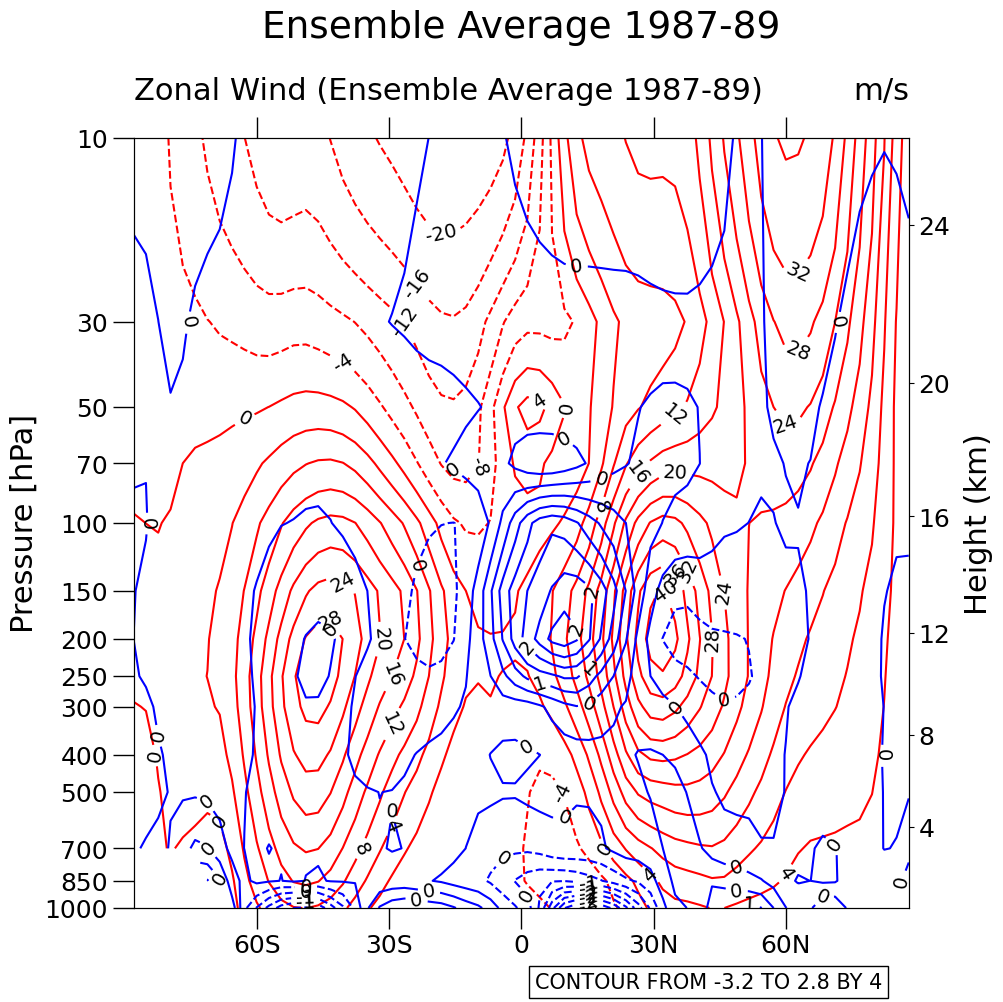

In [7]:
"""
NCL_conOncon_1.py
=================
This script illustrates the following concepts:
   - Drawing pressure/height contours on top of another set of contours
   - Drawing negative contour lines as dashed lines
   - Drawing the zero contour line thicker
   - Changing the color of a contour line
   - Overlaying dashed contours on solid line contours

See following URLs to see the reproduced NCL plot & script:
    - Original NCL script: https://www.ncl.ucar.edu/Applications/Scripts/conOncon_1.ncl
    - Original NCL plot: https://www.ncl.ucar.edu/Applications/Images/conOncon_1_lg.png
"""

################################################################################
# Import packages:

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import metpy.calc as mpcalc
from metpy.units import units

import geocat.datafiles as gdf
import geocat.viz as gv

###############################################################################
# Read in data:

# Open a netCDF data file using xarray default engine and load the data into xarrays
ds = xr.open_dataset(gdf.get("netcdf_files/mxclim.nc"))
# Extract variables
U = ds.U[0, :, :]
V = ds.V[0, :, :]

################################################################################
# Plot:

# Generate figure (set its size (width, height) in inches) and axes
fig = plt.figure(figsize=(10, 10))
ax = plt.gca()

# Set y-axis to have log-scale
plt.yscale('log')

# Contour-plot U-data
p = U.plot.contour(ax=ax, levels=27, colors='red', extend='neither')
ax.clabel(p, fmt='%d', inline=1, fontsize=14, colors='k')

# Contour-plot V-data
p = V.plot.contour(ax=ax, levels=20, colors='blue', extend='neither')
ax.clabel(p, fmt='%d', inline=1, fontsize=14, colors='k')

# Use geocat-viz utility function to add minor ticks to x-axis
gv.add_major_minor_ticks(ax, x_minor_per_major=3, y_minor_per_major=0)

# Use geocat.viz.util convenience function to set axes tick values
# Set y-lim inorder for y-axis to have descending values
gv.set_axes_limits_and_ticks(ax,
                             xticks=np.linspace(-60, 60, 5),
                             xticklabels=['60S', '30S', '0', '30N', '60N'],
                             ylim=ax.get_ylim()[::-1],
                             yticks=U["lev"])

# Change formatter or else we tick values formatted in exponential form
ax.yaxis.set_major_formatter(ScalarFormatter())

# Set font size for y-axis, turn off minor ticks
ax.yaxis.label.set_size(22)

# Adjust length and width of tick marks for left and right y-axis
ax.tick_params('both', length=15, width=1, which='major', labelsize=18)
ax.tick_params('x', length=7, width=0.6, which='minor')

# Use geocat.viz.util convenience function to add titles to left and right of the plot axis.
gv.set_titles_and_labels(ax,
                         maintitle="Ensemble Average 1987-89",
                         maintitlefontsize=25,
                         lefttitle=U.long_name,
                         lefttitlefontsize=22,
                         righttitle=U.units,
                         righttitlefontsize=22,
                         xlabel="")

# Create second y-axis to show geo-potential height.
axRHS = gv.add_height_from_pressure_axis(ax,
                                    heights=np.arange(4, 28, 4),
                                    ticklabelsize=18,
                                    axislabelsize=22)

# Add figure label
fig.text(0.7,
         0.03,
         "CONTOUR FROM -3.2 TO 2.8 BY 4",
         horizontalalignment='center',
         fontsize=15,
         bbox=dict(facecolor='none', edgecolor='k'))

# Show the plot
plt.show()